In [1]:
import pandas as pd
import math
import numpy as np
import queue as pythonQueue
import networkx as nx
import matplotlib.pyplot as plt

Definitions

In [2]:
ATTRIBUTE_NAME = 0
ATTRIBUTE_HEIGHT = 1

Import data from file

In [3]:
data = pd.read_csv('adult.data', header=0, sep=', ', engine='python' )

# Move to lowercase
data.columns = [col.lower() for col in data.columns]

Drop these columns:
- Fnlwgt
- Education-num
- Relationship
- Capital gain
- Capital loss
- Hours-per-week

In [4]:
data.drop(columns=['fnlwgt', 'education_num', 'relationship', 'capital_gain', 'capital_loss', 'hours_per_week'], inplace=True);

Drop rows in which we have unknown values ('?')

In [5]:
data.drop(data[
                (data.workclass == '?') |
                (data.education == '?') |
                (data.marital_status == '?') |
                (data.occupation == '?') |
                (data.race == '?') |
                (data.gender == '?') |
                (data.native_country == '?') |
                (data.salary == '?')].index, inplace=True);

# Domain generalization

For each remaining Q.I. and its corresponding domain, we define a generalization hierarchy, according to this (numbers in parenthesis corresponds to the height of the associated generalization hierarchy)

- Age => 5-, 10-, 20- year ranges (4)
- Workclass => Taxonomy tree (2)
- Education =>  Taxonomy tree (2)
- Marital status => Taxonomy tree (2)
- Occupation => Taxonomy tree (2)
- Race => Suppression (1)
- Gender => Suppression (1)
- Native country => Taxonomy tree (2)
- Salary => Suppression (1)

Code's rule:

the less general version of the data of the Q.I. called 'pippo' is in data['pippo'] . 

For each generalization level n, we will have a variable called pippo_n containing the generalization of the values in data['pippo'], where pippo_1 is LESS general than pippo_2 

### Domain generalization for Age
- 5- year ranges
- 10- year ranges
- 20- year ranges

In [6]:
age = pd.DataFrame({'age_0' : np.sort(pd.unique(data['age']))})
age['age_1'] = (age['age_0']/5).apply(math.floor)*5
age['age_2'] = (age['age_0']/10).apply(math.floor)*10
age['age_3'] = (age['age_0']/20).apply(math.floor)*20

### Domain generalization for Workclass

- Private => Private => Working
- Self-emp-not-inc => Self-Emp => Working
- Self-emp-inc => Self-Emp => Working
- Federal-gov => Federal-gov => Working
- Local-gov => Other-gov => Working
- State-gov => Other-gov => Working
- Without-pay => Not-Working => Not-Working
- Never-worked => Not-Working => Not-Working

In [7]:
workclass = pd.DataFrame({'workclass_0' : np.sort(pd.unique(data['workclass']))})

workclass['workclass_1'] = workclass['workclass_0']
workclass['workclass_1'].where(workclass['workclass_1'] != 'Self-emp-inc', 'Self-Emp', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Self-emp-not-inc', 'Self-Emp', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Local-gov', 'Other-gov', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'State-gov', 'Other-gov', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Never-worked', 'Not-Working', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Without-pay', 'Not-Working', inplace=True)

workclass['workclass_2'] = workclass['workclass_1']
workclass['workclass_2'].where(workclass['workclass_2'] != 'Self-Emp', 'Working', inplace=True)
workclass['workclass_2'].where(workclass['workclass_2'] != 'Federal-gov', 'Working', inplace=True)
workclass['workclass_2'].where(workclass['workclass_2'] != 'Other-gov', 'Working', inplace=True)
workclass['workclass_2'].where(workclass['workclass_2'] != 'Private', 'Working', inplace=True)

### Domain generalization for Education

- "^10th" => "Dropout" => "Low"

- "^11th" => "Dropout" => "Low"

- "^12th" => "Dropout" => "Low"

- "^1st-4th" => "Dropout" => "Low"

- "^5th-6th" => "Dropout" => "Low"

- "^7th-8th" => "Dropout" => "Low"

- "^9th" => "Dropout" => "Low"

- "^Preschool" => "Dropout" => "Low"

- "^Assoc-acdm" => "Associates" => "High"

- "^Assoc-voc" => "Associates" => "High"

- "^Bachelors" => "Bachelors" => "High"

- "^Doctorate" => "Doctorate" => "High"

- "^HS-Grad" => "HS-Graduate" => "High"

- "^Masters" => "Masters" => "High"

- "^Prof-school" => "Prof-School" => "High"

- "^Some-college" => "HS-Graduate" => "High"


In [8]:
education = pd.DataFrame({'education_0' : np.sort(pd.unique(data['education']))})

education['education_1'] = education['education_0']
education['education_1'].where(education['education_1'] != '10th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '11th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '12th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '1st-4th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '5th-6th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '7th-8th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '9th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != 'Preschool', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != 'Assoc-voc', 'Associates', inplace=True)
education['education_1'].where(education['education_1'] != 'Assoc-acdm', 'Associates', inplace=True)
education['education_1'].where(education['education_1'] != 'HS-grad', 'HS-Graduate', inplace=True)
education['education_1'].where(education['education_1'] != 'Some-college', 'HS-Graduate', inplace=True)

education['education_2'] = education['education_1']
education['education_2'].where(education['education_2'] != 'Dropout', 'Low', inplace=True)
education['education_2'].where(education['education_2'] != 'Prof-school', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Associates', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Bachelors', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Masters', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'HS-Graduate', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Doctorate', 'High', inplace=True)

### Domain generalization for Marital status

- Widowed => Widowed => Married
- Divorced => Not-Married => Not-Married
- Married-AF-spouse => Married => Married
- Separated => Not-Married => Not-Married
- Married-spouse-absent => Not-Married => Not-Married
- Married-civ-spouse => Married => Married
- Never-married => Never-Married => Not-Married

In [9]:
marital_status = pd.DataFrame({'marital_status_0' : np.sort(pd.unique(data['marital_status']))})

marital_status['marital_status_1'] = marital_status['marital_status_0']
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Divorced', 'Not-Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Married-AF-spouse', 'Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Separated', 'Not-Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Married-spouse-absent', 'Not-Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Married-civ-spouse', 'Married', inplace=True)

marital_status['marital_status_2'] = marital_status['marital_status_1']
marital_status['marital_status_2'].where(marital_status['marital_status_2'] != 'Widowed', 'Married', inplace=True)
marital_status['marital_status_2'].where(marital_status['marital_status_2'] != 'Never-married', 'Not-Married', inplace=True)

### Domain generalization for Occupation
- Adm-clerical => Admin => A
- Armed-Forces => Military => A
- Craft-repair => Blue-Collar => B
- Exec-managerial => White-Collar => A
- Farming-fishing => Blue-Collar => B
- Handlers-cleaners => Blue-Collar => B
- Machine-op-inspct => Blue-Collar => B
- Other-service => Service => B
- Priv-house-serv => Service => B
- Prof-specialty => Other-Occupations => A
- Protective-serv => Other-Occupations => A
- Sales => Sales => B
- Tech-support => Other-Occupations => A
- Transport-moving => Other-Occupations => A

In [10]:
occupation = pd.DataFrame({'occupation_0' : np.sort(pd.unique(data['occupation']))})

occupation['occupation_1'] = occupation['occupation_0']
occupation['occupation_1'].where(occupation['occupation_1'] != 'Adm-clerical', 'Admin', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Armed-Forces', 'Military', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Craft-repair', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Exec-managerial', 'White-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Farming-fishing', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Handlers-cleaners', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Machine-op-inspct', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Other-service', 'Service', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Priv-house-serv', 'Service', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Prof-specialty', 'Other-Occupations', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Protective-serv', 'Other-Occupations', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Tech-support', 'Other-Occupations', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Transport-moving', 'Other-Occupations', inplace=True)

occupation['occupation_2'] = occupation['occupation_1']
occupation['occupation_2'].where(occupation['occupation_2'] != 'Military', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Sales', 'B', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Admin', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'White-Collar', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Other-Occupations', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Service', 'B', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Blue-Collar', 'B', inplace=True)

### Domain generalization for Race
Based on suppression

In [11]:
race = pd.DataFrame({'race_0' : np.sort(pd.unique(data['race']))})

race['race_1'] = race['race_0']
race['race_1'].where(race['race_1'] != race['race_1'], '*', inplace=True)

### Domain generalization for Gender

Based on suppression

In [12]:
gender = pd.DataFrame({'gender_0' : np.sort(pd.unique(data['gender']))})

gender['gender_1'] = gender['gender_0']
gender['gender_1'].where(gender['gender_1'] != gender['gender_1'], '*', inplace=True)

### Domain generalization for Native Country

- Cambodia => SE-Asia => Asia
- Canada => British-Commonwealth => British-Commonwealth   
- China => Asia => Asia
- Columbia => South-America => South-America
- Cuba => Latin-America => South-America
- Dominican-Republic => Latin-America => South-America
- Ecuador => South-America => South-America
- El-Salvador => South-America => South-America
- England => British-Commonwealth => British-Commonwealth
- France => Euro_1 => Europe
- Germany => Euro_1 => Europe
- Greece => Euro_2 => Europe
- Guatemala => Latin-America => South-America
- Haiti => Latin-America => South-America
- Holand-Netherlands => Euro_1 => Europe
- Honduras => Latin-America => South-America
- Hong => Asia => Asia
- Hungary => Euro_2 => Europe
- India => British-Commonwealth => British-Commonwealth
- Iran => Asia => Asia
- Ireland => British-Commonwealth => British-Commonwealth
- Italy => Euro_1 => Europe
- Jamaica => Latin-America => South-America
- Japan => Asia => Asia
- Laos => SE-Asia => Asia
- Mexico => Latin-America => South-America
- Nicaragua => Latin-America => South-America
- Outlying-US(Guam-USVI-etc) => Latin-America => South-America
- Peru => South-America => South-America
- Philippines => SE-Asia => Asia
- Poland => Euro_2 => Europe
- Portugal => Euro_2 => Europe
- Puerto-Rico => Latin-America => South-America
- Scotland => British-Commonwealth => British-Commonwealth
- South => Euro_2 => Europe
- Taiwan => Asia => Asia
- Thailand => SE-Asia => Asia
- Trinadad&Tobago => Latin-America => South-America
- United-States => United-States => United-States
- Vietnam => SE-Asia => Asia
- Yugoslavia => Euro_2 => Europe

In [13]:
native_country = pd.DataFrame({'native_country_0' : np.sort(pd.unique(data['native_country']))})

native_country['native_country_1'] = native_country['native_country_0']

native_country['native_country_1'].where(native_country['native_country_1'] != 'Cambodia', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Canada', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'China', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Columbia', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Cuba', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Dominican-Republic', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Ecuador', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'El-Salvador', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'England', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'France', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Germany', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Greece', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Guatemala', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Haiti', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Holand-Netherlands', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Honduras', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Hong', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Hungary', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'India', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Iran', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Ireland', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Italy', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Jamaica', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Japan', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Laos', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Mexico', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Nicaragua', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Outlying-US(Guam-USVI-etc)', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Peru', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Philippines', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Poland', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Portugal', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Puerto-Rico', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Scotland', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'South', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Taiwan', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Thailand', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Trinadad&Tobago', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Vietnam', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Yugoslavia', 'Euro_2', inplace=True)

native_country['native_country_2'] = native_country['native_country_1']
native_country['native_country_2'].where(native_country['native_country_2'] != 'Euro_1', 'Europe', inplace=True)
native_country['native_country_2'].where(native_country['native_country_2'] != 'Euro_2', 'Europe', inplace=True)
native_country['native_country_2'].where(native_country['native_country_2'] != 'SE-Asia', 'Asia', inplace=True)
native_country['native_country_2'].where(native_country['native_country_2'] != 'Latin-America', 'South-America', inplace=True)

### Domain generalization for Salary

Based on suppression

In [14]:
salary = pd.DataFrame({'salary_0' : np.sort(pd.unique(data['salary']))})

salary['salary_1'] = salary['salary_0']
salary['salary_1'].where(salary['salary_1'] != salary['salary_1'], '*', inplace=True)

### Domains to array

In [15]:
dimensions = {}
dimensions['age']=age
dimensions['workclass'] = workclass
dimensions['education']=education
dimensions['marital_status']=marital_status
dimensions['occupation']=occupation
dimensions['race']=race
dimensions['gender']=gender
dimensions['native_country']=native_country
dimensions['salary']=salary
#data_concat = data

data_concat = pd.DataFrame()
for dimension in dimensions:
    data_concat = pd.concat([data_concat, dimensions[dimension]], axis=1)

### Graph utilities

### Graph definition
Each node of the graph is a generalization. A node is a tuple of tuples (tuple_1, tuple_2, ..., tuple_n).
Each tuple_i is composed as (Attribute_name, Attribute_generalization).
Ex. (('Age', 0), ('Sex', 0)) is a generalization with respect to columns age_0, sex_0

In [16]:
def generate_graph_0(Q, dimensions):
    G = nx.DiGraph()
    for dimension_name in Q:
        prev = None
        height = 0
        for _ in dimensions[dimension_name].columns:
            l = [(dimension_name, height)]
            #Convert the list to tuple to make it hashable
            current_node = tuple(l)
            
            if prev is not None:
                #from ((age, 0)) to ((age, 1)), then ((age,1)) to ((age, 2))
                G.add_edge(prev, current_node)
                
            height = height + 1
            prev = current_node
    
    return G

In [17]:
def printGraph(G):
    labels = {node:str(node) for node in G.nodes()}
    print(labels)
    nx.draw(G, with_labels=True, labels=labels)
    plt.show()
            

# Incognito algorithm

In [18]:
def frequencySet_standard(T, Q):
    # Add each name of attribute in T the level _0 since it is level 0 generalization:
    #  this way it can easily use the groupby
    tmp_columns = T.columns
    T.columns = [str(col) + '_0' for col in T.columns]
    
    fsSet = T.groupby(Q).count().reset_index()
    fsSet = fsSet.iloc[:, :(len(Q)+1)]
    fsSet.rename({fsSet.columns[(len(Q))] : 'Count'}, axis='columns', inplace=True)
    
    T.columns = tmp_columns
    return fsSet

In [19]:
def frequencySet_fromParent(T, Q, generalizations):
        
    tmpT = T.copy()
    
    for attribute in Q:
        #Extract generalization height from string
        attribute_height = int(attribute[len(attribute)-1])
        
        # If it is not level 0 generalization, join with the corresponding dimension table
        # It will never happen that in Q there will be two level of the same domain, i dont need to control it
        if not attribute_height == 0:
            attribute_name = attribute[:len(attribute)-2]
            tmpT = tmpT.set_index(attribute_name+'_'+str(attribute_height-1))\
                .join(generalizations[attribute_name][[attribute_name+'_'+str(attribute_height),
                                                      attribute_name+'_'+str(attribute_height-1)]]\
                      .set_index(attribute_name+'_'+str(attribute_height-1))).drop_duplicates()
                
    fsSet = tmpT.groupby(Q)['Count'].sum().reset_index()
    fsSet = fsSet.iloc[:, :(len(Q)+1)]
    return fsSet

In [20]:
def computeK(frequencySet):
    return min(frequencySet['Count'])

#### Generate attributes list.  For each attribute, include all its generalizations. 
Ex. if current node is age_1, we shoud group by age_1, age_2 and age_3 because the latter ones will be needed in next iterations in parentFrequencySet. Of course group by(age_1) has the same number of rows of group by (age_1, age_2, age_3)

In [21]:
def getAllAttributesGeneralizations(node, generalizations):
    attributesOfNode = list()
    for attribute in list(node):
            # 0 is the name, 1 is the generalization level
            attributeGeneralizaiton = generalizations[attribute[ATTRIBUTE_NAME]]
            
            for i in range(attribute[ATTRIBUTE_HEIGHT], len(attributeGeneralizaiton.columns)):
                attributesOfNode.append("{}_{}".format(attribute[ATTRIBUTE_NAME], i))
                
    return attributesOfNode

In [22]:
def getNodeAttributes(node):
    attributesOfNode = list()
    for attribute in node:
        attributesOfNode.append("{}_{}".format(attribute[ATTRIBUTE_NAME], attribute[ATTRIBUTE_HEIGHT]))
    return attributesOfNode

In [23]:
def getNodeHeight(node):
        height = 0
        for nodeAttr in node:
            height = height + nodeAttr[ATTRIBUTE_HEIGHT]
        return height

In [24]:
def incognito_standard (k, T, Q, generalizations):
    
    queue = pythonQueue.PriorityQueue()
    
    # Must be initialized outside the for since will be both shared between iterations...
    C_i = generate_graph_0(Q, generalizations) # Graph (C_i, E_i) at iteration i
    S_i = None
    sink = list((node for node, out_degree in C_i.out_degree() if out_degree == 0))[0]
    for i in range(0, len(Q)-3):
        # It is not a problem if we copy the whole graph instead of copying
        #  only the nodes since every time we use S_i we delete nodes, and
        #  therefore we also delete edges attached to these nodes
        S_i = C_i.copy()
        marked = set()
        
        # Insert all roots node into queue, keeping queue sorted by height
        for node in C_i.nodes():
            if C_i.in_degree(node) == 0:
                height = getNodeHeight(node)
                # First parameter is height, second is data
                queue.put((height, node))
        
        while not queue.empty():
            height, node = queue.get()
            if node not in marked:
                attributesOfNode = getNodeAttributes(node)
                # if node was initally a root
                if C_i.in_degree(node) == 0:
                    frequencySet = frequencySet_standard(T, attributesOfNode)
                    print(node, "done")
                else:
                    frequencySetParent = S_i.node[node]['parentFrequencySet']
                    frequencySet = frequencySet_fromParent(frequencySetParent, attributesOfNode, generalizations)
                    print(node, "done")
                    
                actual_k = computeK(frequencySet)
                # If T is k-anonymous with respect to attributes of node
                if (actual_k >= k):
                    # mark all direct generalizations of node
                    for generalizationPath in nx.all_simple_paths(S_i, source=node, target=sink):
                        for pathNode in generalizationPath:
                            marked.add(pathNode)
                else:
                    # Set childs frequency set to this one
                    for child in S_i.out_edges(node):
                        S_i.node[child[1]]['parentFrequencySet'] = frequencySet
                        height = getNodeHeight(child[1])
                        queue.put((height, child[1]))
                      
                    #print("Removed node: {}".format(node))
                    S_i.remove_node(node)
                    
        #COMPUTE C_i+1
    return S_i

In [25]:
def incognito_super_root (k, T, Q, generalizations):
    
    queue = pythonQueue.PriorityQueue()
    
    # Must be initialized outside the for since will be both shared between iterations...
    C_i = generate_graph_0(Q, generalizations) # Graph (C_i, E_i) at iteration i
    S_i = None
    sink = list((node for node, out_degree in C_i.out_degree() if out_degree == 0))[0]
    
    for i in range(0, 1):
        S_i = C_i.copy()
        marked = set()
        
        #dictionary containing for each generalized node the corresponding frequencySet
        rootFrequencySet = {}
        #set containing roots
        rootSet = set()
        
        # Insert all roots node into queue, keeping queue sorted by height
        for node in C_i.nodes():
            if C_i.in_degree(node) == 0:
                rootSet.add(node)
                height = getNodeHeight(node)
                # First parameter is height, second is data
                queue.put((height, node))
        
        # Given a set of roots, try to find if there are common ancestors of some of them and compute freqSet at level 0        
        while not queue.empty():
            height, node = queue.get()
            if node not in marked:
                attributesOfNode = getNodeAttributes(node)
                # if node was initally a root
                if C_i.in_degree(node) == 0:
                    frequencySet = frequencySet_standard(T, attributesOfNode)
                    print(node, "done")
                else:
                    frequencySetParent = S_i.node[node]['parentFrequencySet']
                    frequencySet = frequencySet_fromParent(frequencySetParent, attributesOfNode, generalizations)
                actual_k = computeK(frequencySet)
                # If T is k-anonymous with respect to attributes of node
                if (actual_k >= k):
                    # mark all direct generalizations of node
                    for generalizationPath in nx.all_simple_paths(S_i, source=node, target=sink):
                        for pathNode in generalizationPath:
                            marked.add(pathNode)
                else:
                    # Set childs frequency set to this one
                    for child in S_i.out_edges(node):
                        S_i.node[child[1]]['parentFrequencySet'] = frequencySet
                        height = getNodeHeight(child[1])
                        queue.put((height, child[1]))
                      
                    #print("Removed node: {}".format(node))
                    S_i.remove_node(node)
                    
        #COMPUTE C_i+1
    return S_i

# Tests

Some code to do tests and similar

Notes:
- il codice e' ok, non mi torna il fatto che come T in input gli passi una tabella che e' la tabella originale con attaccate tutte le possibili generalizzazioni, che in teoria sono in dimensions
- relazione fra frequencyset_standard e frequencyset_fromparent non mi convince


In [26]:
incognito_standard(50, data,['age', 'workclass', 'education', 'marital_status'], dimensions)

(('age', 0),) done
(('education', 0),) done
(('marital_status', 0),) done
(('workclass', 0),) done
(('age', 1),) done
(('education', 1),) done
(('marital_status', 1),) done
(('workclass', 1),) done
(('age', 2),) done
(('workclass', 2),) done
(('age', 3),) done


(('age', 0),) done
(('education', 0),) done
(('marital_status', 0),) done
(('workclass', 0),) done
(('age', 1),) done
(('education', 1),) done
(('marital_status', 1),) done
(('workclass', 1),) done
(('age', 2),) done
(('workclass', 2),) done
(('age', 3),) done
{(('age', 3),): "(('age', 3),)", (('education', 1),): "(('education', 1),)", (('education', 2),): "(('education', 2),)", (('marital_status', 1),): "(('marital_status', 1),)", (('marital_status', 2),): "(('marital_status', 2),)"}


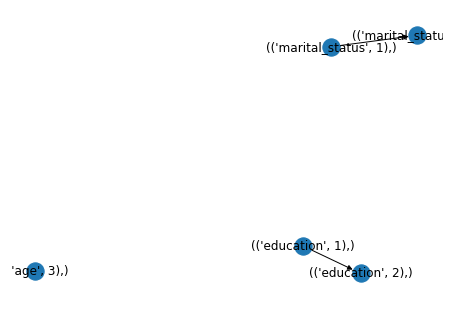

In [38]:
result = incognito_standard(50, data, ['age', 'workclass', 'education', 'marital_status'], dimensions)
printGraph(result)

{(('age', 0),): "(('age', 0),)", (('age', 1),): "(('age', 1),)", (('age', 2),): "(('age', 2),)", (('age', 3),): "(('age', 3),)", (('workclass', 0),): "(('workclass', 0),)", (('workclass', 1),): "(('workclass', 1),)", (('workclass', 2),): "(('workclass', 2),)", (('education', 0),): "(('education', 0),)", (('education', 1),): "(('education', 1),)", (('education', 2),): "(('education', 2),)", (('marital_status', 0),): "(('marital_status', 0),)", (('marital_status', 1),): "(('marital_status', 1),)", (('marital_status', 2),): "(('marital_status', 2),)"}


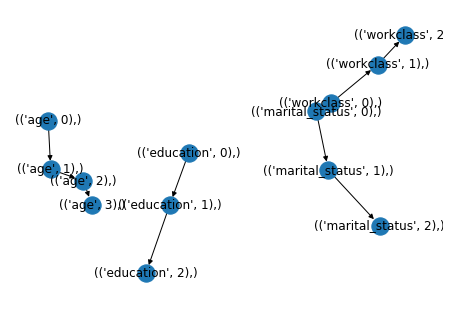

In [35]:
graph = generate_graph_0( ['age', 'workclass', 'education', 'marital_status'], dimensions)
printGraph(graph)